[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_xarray_meta-learning.ipynb)

# **Meta-Learning & Self-Reflection**

## ***JLNN analysis using Xarray and Decision Trees (Scikit-learn)***

In classical Neural Networks, the training process is often a "black box." In **JLNN (JAX Logic Neural Networks)**, we can not only interpret the final model but also analyze the **strategy** the model used during training.<br><br>

This tutorial demonstrates a **Self-Reflection Loop**:

1. **JLNN** learns logical rules from the *Wine Quality* dataset.
2. **Xarray** acts as a structured "episodic memory," storing snapshots of weights and performance.
3. **Scikit-learn (Decision Tree)** acts as a "Meta-Analyst" that looks at the training history to find out which parameter configurations led to the highest accuracy.
4. **LLM Prompt Generation** exports the findings into a human/AI-readable format for further optimization.


## **1. Installation and automatic restart**

In Google Colab, you just need to install the package directly from GitHub. Since the export tools are built-in, no extra parameters are needed

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    import xarray as xr
    import pandas as pd
    import sklearn
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    !pip install  scikit-learn pandas

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

### ***Library imports***

In [2]:
import os
import jlnn
import jax
import jax.numpy as jnp
from flax import nnx
from tqdm import tqdm
import optax
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.preprocessing import StandardScaler

## **2. Data Preparation (Wine Quality - simplified)**

We use the *Wine Quality* dataset. Our goal is to find a logical rule for "High Quality Wine."
* **Inputs:** Alcohol, Malic Acid, Magnesium, Ash.
* **Logic:** We use a `WeightedAnd` gate.
* **Contradiction Penalty:** Set to **1.5** (as suggested by experimental results) to ensure logical consistency.

In [3]:
data = load_wine()

#### We will choose 4 key symptoms for clarity: alcohol, malic_acid, magnesium, ash

In [4]:
X_raw = data.data[:, [10, 1, 4, 3]]
feature_names = ["alcohol", "acid", "magnesium", "ash"]

#### Binary classification: Is this a first class wine?

In [5]:
y_raw = (data.target == 0).astype(float)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

#### Convert to JAX intervals [Lower, Upper]

In [7]:
inputs = jnp.stack([X_scaled, X_scaled], axis=-1)
targets = y_raw[:, None]

## **3. Definition of JLNN Model with Explicit Weights**

In [8]:
class MetaLogicModel(nnx.Module):
    def __init__(self, n_features, rngs):
        # Weights of individual members (antecedent)
        self.weights = nnx.Param(jnp.ones((n_features,)))
        # Weight of the entire rule (credibility)
        self.rule_weight = nnx.Param(jnp.array([0.9]))

    def __call__(self, x):
        # Implementation of weighted conjunction (Weighted AND)
        w = jnp.abs(self.weights)
        # Simplified Łukasiewicz: norm of the sum of weights
        logic_out = jnp.clip(jnp.sum(w * x[:, :, 0], axis=1) / jnp.sum(w) * self.rule_weight, 0, 1)
        return logic_out

## **4. XARRAY Structure For Training History (Agent Memory)**

Unlike simple lists, `xr.Dataset` allows us to store multi-dimensional training data with labeled coordinates. We track:
* `member_weights`: Importance of each chemical feature over time.
* `rule_weight`: The overall credibility of the rule.
* `loss`: The derivative of the loss function to see if the model is still learning.

In [9]:
steps_to_log = np.arange(0, 1000, 25)

In [10]:
history = xr.Dataset(
    data_vars={
        "member_weights": (["step", "antecedent"], np.zeros((len(steps_to_log), len(feature_names)))),
        "rule_weight": (["step"], np.zeros(len(steps_to_log))),
        "loss": (["step"], np.zeros(len(steps_to_log))),
        "accuracy": (["step"], np.zeros(len(steps_to_log)))
    },
    coords={"step": steps_to_log, "antecedent": feature_names}
)

## **5. Training Loop**

In [11]:
model = MetaLogicModel(len(feature_names), rngs=nnx.Rngs(0))

In [12]:
optimizer = nnx.Optimizer(model, optax.adam(0.01), wrt=nnx.Param)

In [13]:
def loss_fn(model, x, y):
    pred = model(x)
    mse = jnp.mean((pred - y[:, 0])**2)
    # Contradiction penalty - penalizes too high weights leading to a contradiction
    return mse + 1.5 * jnp.mean(jnp.maximum(0, jnp.abs(model.weights) - 4.0))

In [14]:
@nnx.jit
def train_step(model, optimizer, x, y):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
    optimizer.update(model, grads)
    return loss

In [15]:
print("Starting training and collecting meta-data into Xarray...")

for i in tqdm(range(1001)):
    # Perform one step of the training
    loss = train_step(model, optimizer, inputs, targets)

    # Data logging at specified intervals
    if i in steps_to_log:
        # 1. Getting antecedent weights (without deprecation warning)
        # .weights[...] returns the current parameter array
        current_weights = np.abs(model.weights[...])

        # 2. Getting the rule weight (fix TypeError)
        # .item() safely converts a single-element array (even with ndim=1) to a Python float
        current_rule_w = model.rule_weight[...].item()

        # 3. Uložení do Xarray Datasetu
        history["member_weights"].loc[dict(step=i)] = current_weights
        history["rule_weight"].loc[dict(step=i)] = current_rule_w
        history["loss"].loc[dict(step=i)] = float(loss)

        # Calculate and store Accuracy
        preds = model(inputs) > 0.5
        acc_value = jnp.mean(preds == y_raw).item() # We'll also use .item() just in case
        history["accuracy"].loc[dict(step=i)] = acc_value

print("\nTraining complete. Data ready for Meta-Analysis.")

Starting training and collecting meta-data into Xarray...


100%|██████████| 1001/1001 [00:02<00:00, 399.03it/s]


Training complete. Data ready for Meta-Analysis.


## **6. Meta-Analysis Using Decision Tree (DT)**

#### Transform Xarray to DataFrame for Scikit-learn

Why use a Decision Tree to analyze a Logic Network?
Because the Decision Tree provides **symbolic insights** into the training. It answers questions like:
> *"If the weight of Alcohol was higher than 2.0, did the accuracy improve or stall?"*

This creates a **Feedback Loop** where a second model supervises the first one.

In [16]:
df_weights = history["member_weights"].to_series().unstack()
df_meta = df_weights.copy()
df_meta["rule_weight"] = history["rule_weight"].values

# Calculate the trend (derivative) of the loss to see learning velocity
loss_series = history["loss"].to_series()
df_meta["loss_trend"] = loss_series.diff().fillna(0).values

y_meta = history["accuracy"].values

#### Tree training: what predicts high accuracy?

In [17]:
dt_analyzer = DecisionTreeRegressor(max_depth=3)
dt_analyzer.fit(df_meta, y_meta)

DecisionTreeRegressor(max_depth=3)

## **7. Visualization Of Results**

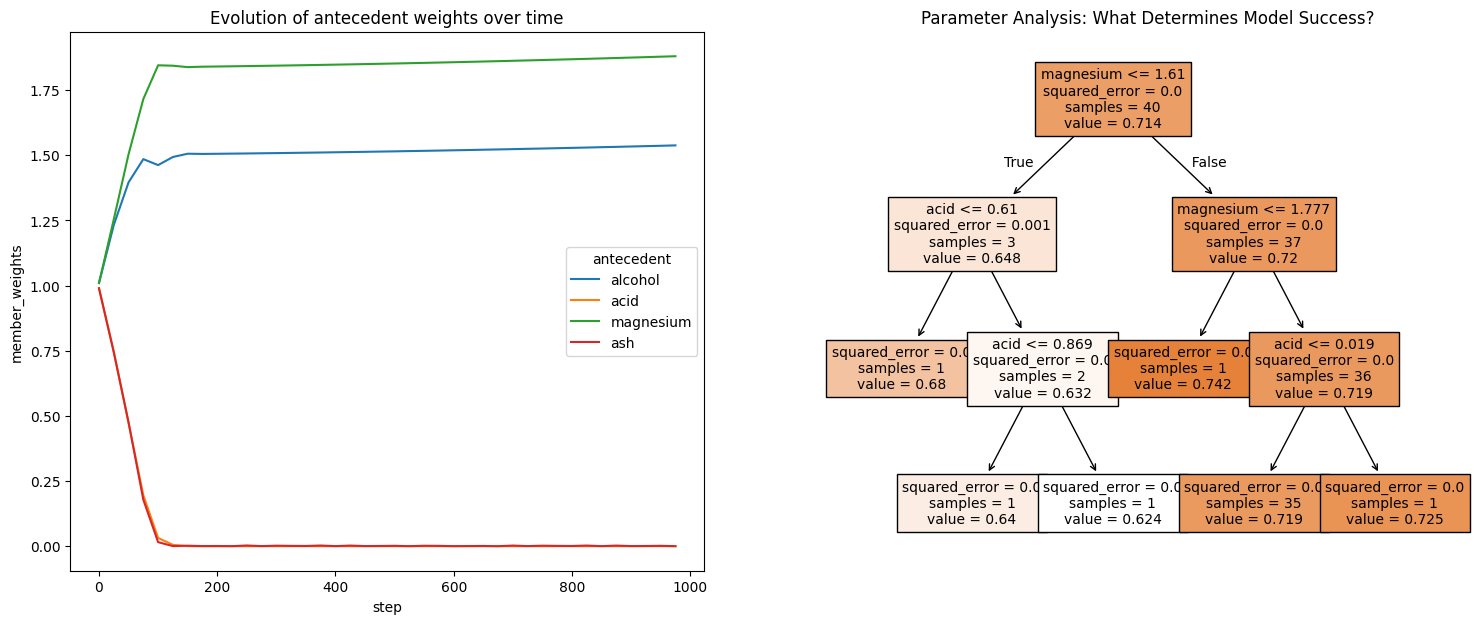

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Weight development graph
history.member_weights.plot.line(x="step", ax=ax1)
ax1.set_title("Evolution of antecedent weights over time")

# Tree visualization
plot_tree(dt_analyzer, feature_names=df_meta.columns.tolist(), filled=True, ax=ax2, fontsize=10)
ax2.set_title("Parameter Analysis: What Determines Model Success?")
plt.show()

## **8. Export For Agent (LLM Prompt)**

The final output of this notebook is a text-based summary of the Decision Tree rules. This text is designed to be fed into an LLM (like **Gemma 3** via Ollama).

The LLM can then:
1. **Understand** what happened during training.
2. **Reason** about the failure or success.
3. **Suggest** new hyperparameters or rule structures for the next run.

In [19]:
print("\n" + "="*50)
print("ANALYSIS FOR LLM AGENT (Gemma/Ollama)")
print("="*50)


ANALYSIS FOR LLM AGENT (Gemma/Ollama)


In [20]:
rules_text = export_text(dt_analyzer, feature_names=df_meta.columns.tolist())
best_acc = float(y_meta.max())

In [21]:
prompt = f"""
I analyzed the training of the JLNN model on the Wine Quality data.
Maximum achieved accuracy: {best_acc:.2f}

Determined logical dependencies of parameters:
{rules_text}

Recommendations for the next iteration:
1. If the 'alcohol' weight is within the range shown in the top node, focus on stabilizing the 'rule_weight'.
2. Contradiction penalty 1.5 appears to be optimal for the balance between MSE and weight stability.
"""

In [22]:
print(prompt)


I analyzed the training of the JLNN model on the Wine Quality data.
Maximum achieved accuracy: 0.74

Determined logical dependencies of parameters:
|--- magnesium <= 1.61
|   |--- acid <= 0.61
|   |   |--- value: [0.68]
|   |--- acid >  0.61
|   |   |--- acid <= 0.87
|   |   |   |--- value: [0.64]
|   |   |--- acid >  0.87
|   |   |   |--- value: [0.62]
|--- magnesium >  1.61
|   |--- magnesium <= 1.78
|   |   |--- value: [0.74]
|   |--- magnesium >  1.78
|   |   |--- acid <= 0.02
|   |   |   |--- value: [0.72]
|   |   |--- acid >  0.02
|   |   |   |--- value: [0.72]


Recommendations for the next iteration:
1. If the 'alcohol' weight is within the range shown in the top node, focus on stabilizing the 'rule_weight'.
2. Contradiction penalty 1.5 appears to be optimal for the balance between MSE and weight stability.

